In [72]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os,cv2
import numpy as np
from IPython.display import Image
from keras.preprocessing import image
from keras import optimizers
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
import seaborn as sns
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.applications.vgg16 import VGG16 , preprocess_input
from keras.layers import  Conv2D,MaxPooling2D,Dropout,Activation, Flatten, Dense,GlobalAveragePooling2D
from keras.optimizers import Adam , RMSprop
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pwd

/kaggle/working


In [3]:
cd /kaggle/input/

/kaggle/input


In [6]:
train_dir="../input/eight-dance-forms/train"
test_dir="../input/eight-dance-forms/test"
train=pd.read_csv('../input/eight-dance-forms/train.csv')
test = pd.read_csv('../input/eight-dance-forms/test.csv')
print('no of training images ',train.shape[0])
print('no of test images ',test.shape[0])
train.head()

no of training images  364
no of test images  156


,Image,target
0,96.jpg,manipuri
1,163.jpg,bharatanatyam
2,450.jpg,odissi
3,219.jpg,kathakali
4,455.jpg,odissi


In [7]:
pwd

'/kaggle/input'

In [ ]:
cd eight-dance-forms

In [8]:
train_fnames = os.listdir(train_dir)
test_fnames = os.listdir(test_dir)

print(train_fnames[:9])
print(test_fnames[:9])

['230.jpg', '443.jpg', '455.jpg', '27.jpg', '504.jpg', '268.jpg', '186.jpg', '127.jpg', '305.jpg']
['238.jpg', '495.jpg', '64.jpg', '6.jpg', '125.jpg', '226.jpg', '398.jpg', '38.jpg', '349.jpg']


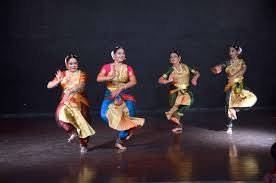

In [12]:
Image(os.path.join(train_dir,train.iloc[1,0]),width=250,height=250)

In [24]:
datagen=ImageDataGenerator(rescale=1./255,validation_split=0.25)

train_generator=datagen.flow_from_dataframe(dataframe=train,directory=train_dir,x_col='Image',
                                            y_col='target',class_mode='categorical',batch_size=8,
                                            target_size=(224,224),color_mode='rgb',seed=42)


validation_generator=datagen.flow_from_dataframe(dataframe=train,directory=train_dir,x_col='Image',
                                                y_col='target',class_mode='categorical',batch_size=8,
                                                target_size=(224,224),color_mode='rgb',seed=42)

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(dataframe=test,directory=test_dir,x_col="Image",y_col=None,
                                                        batch_size=32,seed=42,shuffle=False,
                                                            class_mode=None,target_size=(224,224),color_mode='rgb')

Found 364 validated image filenames belonging to 8 classes.
Found 364 validated image filenames belonging to 8 classes.
Found 156 validated image filenames.


In [68]:
from keras.applications import MobileNet

In [96]:
base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x = Dropout(0.5)(x)
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dropout(0.5)(x)
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(8,activation='softmax')(x) #final layer with softmax activation
model=Model(inputs=base_model.input,outputs=preds)



In [97]:
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [98]:
pwd

'/kaggle/working'

In [101]:
early = EarlyStopping(monitor='val_loss',patience=5,verbose=1,restore_best_weights=True)
checkpoint = ModelCheckpoint('model.h5', monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["accuracy"])

In [102]:

history=model.fit_generator(train_generator,epochs=25,
                            validation_data=validation_generator,
                            callbacks=[early,checkpoint])

Epoch 1/25
45/46 [============================>.] - ETA: 0s - loss: 2.6636 - accuracy: 0.2191
Epoch 00001: val_accuracy improved from -inf to 0.27747, saving model to model.h5
46/46 [==============================] - 12s 255ms/step - loss: 2.6491 - accuracy: 0.2225 - val_loss: 2.8276 - val_accuracy: 0.2775
Epoch 2/25
46/46 [==============================] - ETA: 0s - loss: 1.5601 - accuracy: 0.4176
Epoch 00002: val_accuracy improved from 0.27747 to 0.45055, saving model to model.h5
46/46 [==============================] - 11s 245ms/step - loss: 1.5601 - accuracy: 0.4176 - val_loss: 1.4193 - val_accuracy: 0.4505
Epoch 3/25
46/46 [==============================] - ETA: 0s - loss: 1.2119 - accuracy: 0.5879
Epoch 00003: val_accuracy improved from 0.45055 to 0.60165, saving model to model.h5
46/46 [==============================] - 11s 242ms/step - loss: 1.2119 - accuracy: 0.5879 - val_loss: 1.4481 - val_accuracy: 0.6016
Epoch 4/25
46/46 [==============================] - ETA: 0s - loss: 0.

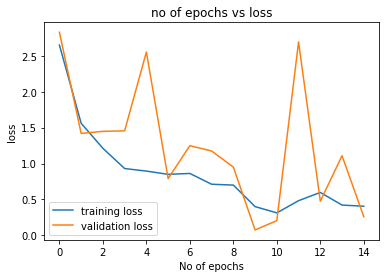

In [103]:
acc=history.history['loss'] 
acc_val=history.history['val_loss']

epochs_ = range(len(acc))
plt.plot(epochs_,acc,label='training loss')
plt.xlabel('No of epochs')
plt.ylabel('loss')

  ## getting validation loss of each epochs
plt.plot(epochs_,acc_val,label="validation loss")
plt.title('no of epochs vs loss')
plt.legend()

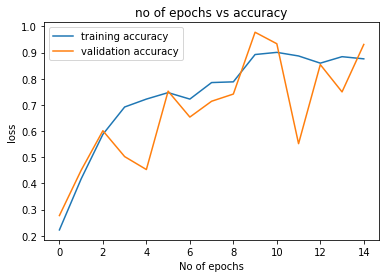

In [104]:
acc=history.history['accuracy'] 
acc_val=history.history['val_accuracy']

epochs_ = range(len(acc))
plt.plot(epochs_,acc,label='training accuracy')
plt.xlabel('No of epochs')
plt.ylabel('loss')

  ## getting validation loss of each epochs
plt.plot(epochs_,acc_val,label="validation accuracy")
plt.title('no of epochs vs accuracy')
plt.legend()

In [105]:
model.load_weights('model.h5')

In [106]:
model.evaluate_generator(generator=validation_generator)

[0.07632027566432953, 0.9780219793319702]

In [107]:
test_generator.reset()
pred=model.predict_generator(test_generator,verbose=1)
pred

5/5 [==============================] - 2s 321ms/step


array([[4.9771722e-03, 2.6919167e-02, 7.7254060e-03, ..., 3.9048988e-04,
        8.9974451e-01, 6.7453971e-04],
       [7.8639202e-03, 4.4703698e-03, 3.4121366e-03, ..., 9.2365664e-01,
        3.0701010e-02, 1.6801903e-02],
       [1.7931150e-05, 2.2826061e-05, 6.7332716e-05, ..., 6.1092319e-06,
        9.9967408e-01, 1.2579383e-06],
       ...,
       [2.4184749e-04, 9.9824154e-01, 5.7937455e-06, ..., 2.9845271e-06,
        1.0515099e-03, 1.5639465e-06],
       [5.8512310e-06, 8.9517298e-06, 8.2247483e-05, ..., 7.3804807e-07,
        9.9975032e-01, 2.9359009e-07],
       [7.7916484e-04, 3.0120980e-04, 1.4138047e-04, ..., 8.1181270e-04,
        2.5568146e-04, 9.8712569e-01]], dtype=float32)

In [108]:
predicted_class_indices=np.argmax(pred,axis=1)
predicted_class_indices

array([6, 5, 6, 6, 0, 3, 6, 2, 3, 6, 6, 0, 7, 5, 5, 0, 6, 1, 5, 3, 6, 2,
       2, 7, 5, 2, 6, 0, 3, 0, 5, 3, 1, 0, 5, 3, 6, 6, 1, 3, 1, 1, 6, 7,
       5, 5, 1, 7, 2, 3, 5, 6, 1, 3, 1, 5, 1, 6, 3, 0, 2, 4, 1, 3, 3, 3,
       2, 3, 3, 6, 1, 6, 2, 7, 6, 2, 6, 0, 2, 1, 5, 7, 7, 6, 6, 3, 1, 1,
       4, 2, 4, 1, 3, 0, 6, 1, 5, 2, 1, 3, 6, 0, 1, 6, 3, 6, 2, 3, 4, 6,
       1, 2, 3, 6, 3, 6, 2, 2, 5, 6, 6, 3, 0, 5, 6, 5, 5, 5, 1, 6, 0, 7,
       0, 3, 4, 6, 3, 7, 0, 1, 7, 1, 4, 2, 6, 2, 1, 5, 4, 6, 5, 7, 1, 1,
       6, 7])

In [109]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
predictions

['odissi',
 'mohiniyattam',
 'odissi',
 'odissi',
 'bharatanatyam',
 'kuchipudi',
 'odissi',
 'kathakali',
 'kuchipudi',
 'odissi',
 'odissi',
 'bharatanatyam',
 'sattriya',
 'mohiniyattam',
 'mohiniyattam',
 'bharatanatyam',
 'odissi',
 'kathak',
 'mohiniyattam',
 'kuchipudi',
 'odissi',
 'kathakali',
 'kathakali',
 'sattriya',
 'mohiniyattam',
 'kathakali',
 'odissi',
 'bharatanatyam',
 'kuchipudi',
 'bharatanatyam',
 'mohiniyattam',
 'kuchipudi',
 'kathak',
 'bharatanatyam',
 'mohiniyattam',
 'kuchipudi',
 'odissi',
 'odissi',
 'kathak',
 'kuchipudi',
 'kathak',
 'kathak',
 'odissi',
 'sattriya',
 'mohiniyattam',
 'mohiniyattam',
 'kathak',
 'sattriya',
 'kathakali',
 'kuchipudi',
 'mohiniyattam',
 'odissi',
 'kathak',
 'kuchipudi',
 'kathak',
 'mohiniyattam',
 'kathak',
 'odissi',
 'kuchipudi',
 'bharatanatyam',
 'kathakali',
 'manipuri',
 'kathak',
 'kuchipudi',
 'kuchipudi',
 'kuchipudi',
 'kathakali',
 'kuchipudi',
 'kuchipudi',
 'odissi',
 'kathak',
 'odissi',
 'kathakali',
 's

In [110]:
pwd

'/kaggle/working'

In [111]:
cd /kaggle/working/

/kaggle/working


In [112]:
filenames=test_generator.filenames
results=pd.DataFrame({"Image":filenames,
                      "target":predictions})
results.to_csv("mobile_results.csv",index=False)

In [113]:
result = pd.read_csv('./mobile_results.csv')
result.head()

,Image,target
0,508.jpg,odissi
1,246.jpg,mohiniyattam
2,473.jpg,odissi
3,485.jpg,odissi
4,128.jpg,bharatanatyam


In [66]:
pwd

'/kaggle/working'